In [44]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from policynetwork import PolicyNetwork
from gaussian_action_noise import GaussianActionNoise
from ddpg_agent import DDPGAgent
from replaybuffer import ReplayBuffer
from subplot_curves import subplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:


#Create random agent
# random_agent = RandomAgent(pendulum)
# heuristic_agent = HeuristicPendulumAgent(pendulum)

In [46]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [62]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99
NOISE_STD = 0.3

In [76]:
torch.manual_seed(-1)

#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

noise = GaussianActionNoise(NOISE_STD)

critic  = QNetwork().to(device) # critic
actor = PolicyNetwork().to(device) # policy_network

memory = ReplayBuffer(max_size=BUFFER_SIZE)
agent = DDPGAgent(actor, noise)

In [77]:

q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)
policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [57]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, agent, gamma, critic, iter, q_optimizer):
    #compute loss for critic

    action_next_state = agent.compute_action(state = next_state_batch) # np

    # To compute the targets in each step, do not use the on-trajectory action, 
    # but compute a new action according to the policy
    network_input_state = torch.cat((state_batch, action_batch.T),1)
    network_input_next_state = torch.cat((next_state_batch, action_next_state),1)

    with torch.no_grad():
        # network_input_next_state or network_input_state
        q_next = critic(network_input_next_state) # should not be differentiated 

    if iter == MAX_IT:
        q_next = 0
    target_state = reward_batch + gamma * q_next # the last update in each episode should use q = 0 ?
    q = critic(network_input_state)
    #q_state.append(q)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss


In [58]:
def test_policy(state_batch, actor, critic):

    #compute loss for actor
    
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    with torch.no_grad():
        policy_loss = -critic(policy_input_state)
        policy_loss = policy_loss.mean()
    
    
    return policy_loss

In [65]:
def learning_policy(state_batch, policy_optimizer, actor, critic):

    #compute loss for actor
    policy_optimizer.zero_grad()
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    policy_loss = -critic(policy_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

In [30]:
policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
policy_loss = -critic(policy_input_state)
policy_loss

tensor([[0.2915],
        [0.2842],
        [0.1604],
        [0.1519],
        [0.2873],
        [0.3125],
        [0.1738],
        [0.1898],
        [0.2910],
        [0.3060],
        [0.1666],
        [0.3009],
        [0.1618],
        [0.1535],
        [0.1607],
        [0.1494],
        [0.1717],
        [0.2758],
        [0.2950],
        [0.1723],
        [0.2505],
        [0.1747],
        [0.1806],
        [0.2253],
        [0.2644],
        [0.2454],
        [0.1536],
        [0.2413],
        [0.2077],
        [0.1725],
        [0.1677],
        [0.1699],
        [0.2106],
        [0.2484],
        [0.1922],
        [0.3019],
        [0.1671],
        [0.1788],
        [0.1502],
        [0.1511],
        [0.2797],
        [0.2248],
        [0.2344],
        [0.3036],
        [0.1796],
        [0.1607],
        [0.1650],
        [0.1615],
        [0.1645],
        [0.1731],
        [0.2894],
        [0.1714],
        [0.1754],
        [0.2683],
        [0.2377],
        [0

In [78]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
nr_of_samples = 128

PRINT_EVERY = 50


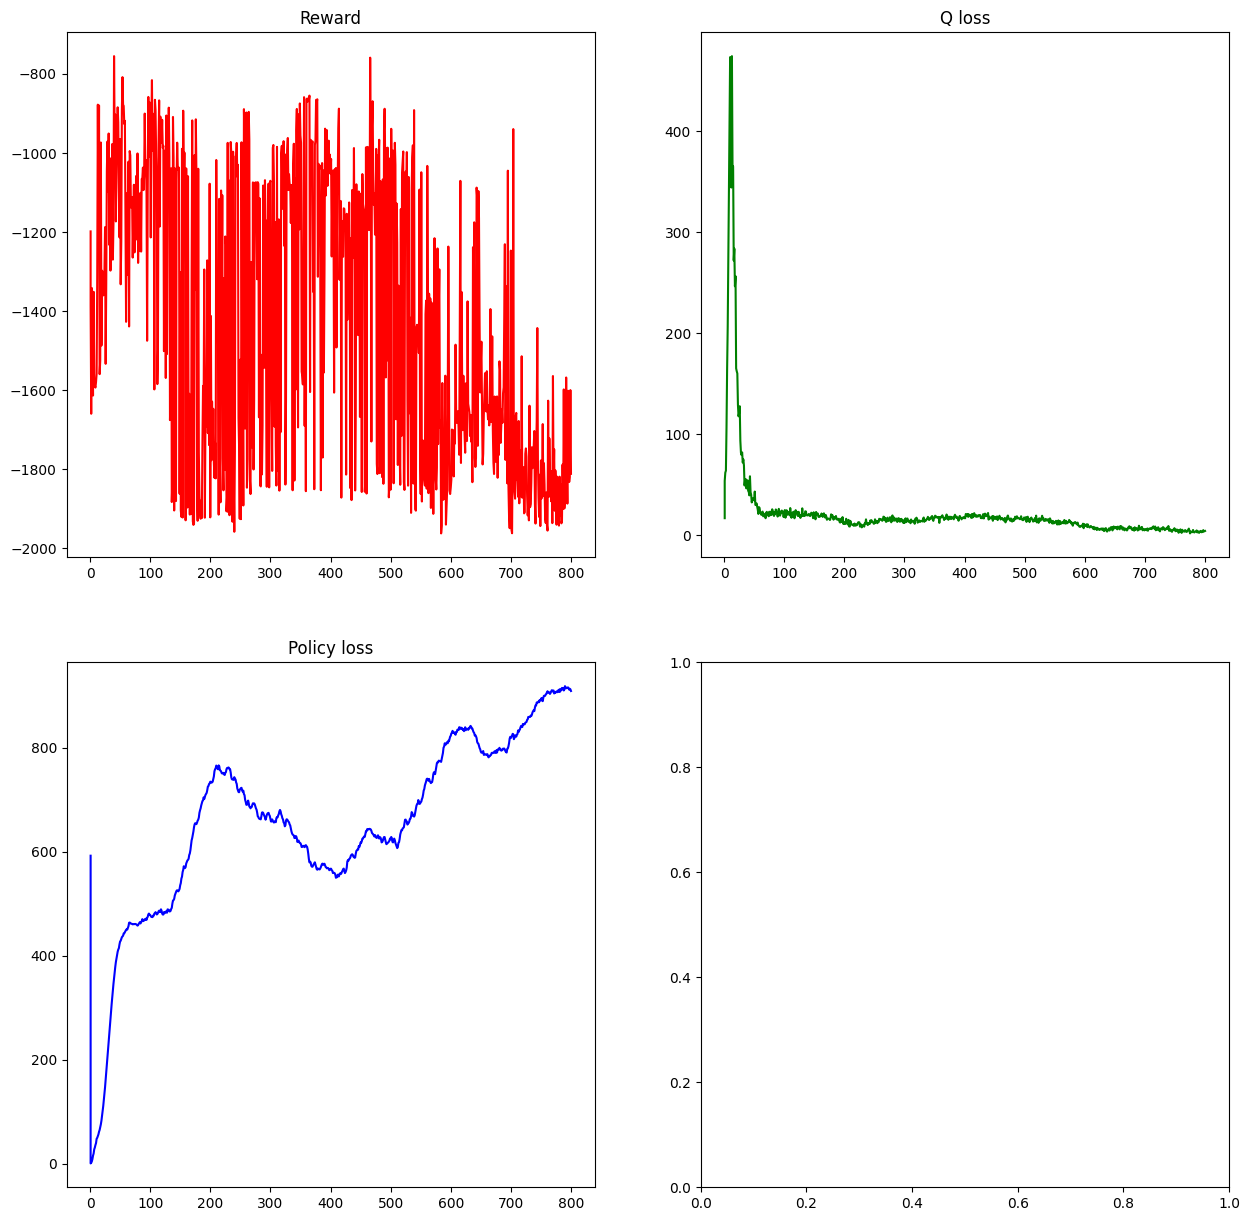

 80%|████████  | 800/1000 [18:10<04:57,  1.49s/it]

[   800 episode,        0 total steps] average reward for past 50 iterations: -22841.403


 84%|████████▍ | 840/1000 [19:03<03:37,  1.36s/it]

In [101]:
q_losses = []
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        #TODO: False ??
        action = agent.compute_action(state = current_state, device=device, deterministic=False)
        num_action = action.numpy()
        #transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(num_action)

        memory.add_transition(state = current_state, action = num_action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > 2*nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
            action_batch = torch.FloatTensor(np.array([action_batch])).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) #.unsqueeze(1)
            trunc_batch = torch.Tensor(np.array([np.float32(trunc_batch)])).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)

            # 1-step TD-learning rule
            

            # To compute the targets in each step, do not use the on-trajectory action, 
            # but compute a new action according to the policy
                      
            action_next_state = agent.compute_action(state = next_state_batch, device=device) # no grad
            with torch.no_grad():
                network_input_next_state = torch.cat((next_state_batch, torch.Tensor(action_next_state)),1)
                #print(network_input_next_state)
                # network_input_next_state or network_input_state
                q_next = critic(network_input_next_state) # should not be differentiated 

            if iter == MAX_IT:
                q_next = 0
            target_state = reward_batch + GAMMA * q_next # the last update in each episode should use q = 0 ?
            
            network_input_state = torch.cat((state_batch, action_batch.T),1)
            q = critic(network_input_state)
            #q_state.append(q)

            q_optimizer.zero_grad()
            q_loss = MSE(target_state, q)
            q_loss.backward()
            q_optimizer.step()

            #q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, agent, GAMMA, critic, i, q_optimizer)

            #TODO:  doesn't learn
            policy_loss = learning_policy(state_batch, policy_optimizer, actor, critic)
            
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    # plot_q.append([loss, episode])
    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])
        # q_losses.append(q_loss.item())

        # if (episode % 100 == 0):
        #     print(policy_loss.item())
    except:
        continue
    average_reward += ep_reward

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
              (episode + 1, global_step, average_reward / PRINT_EVERY))
        #print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        #average_reward = 0 #reset average reward


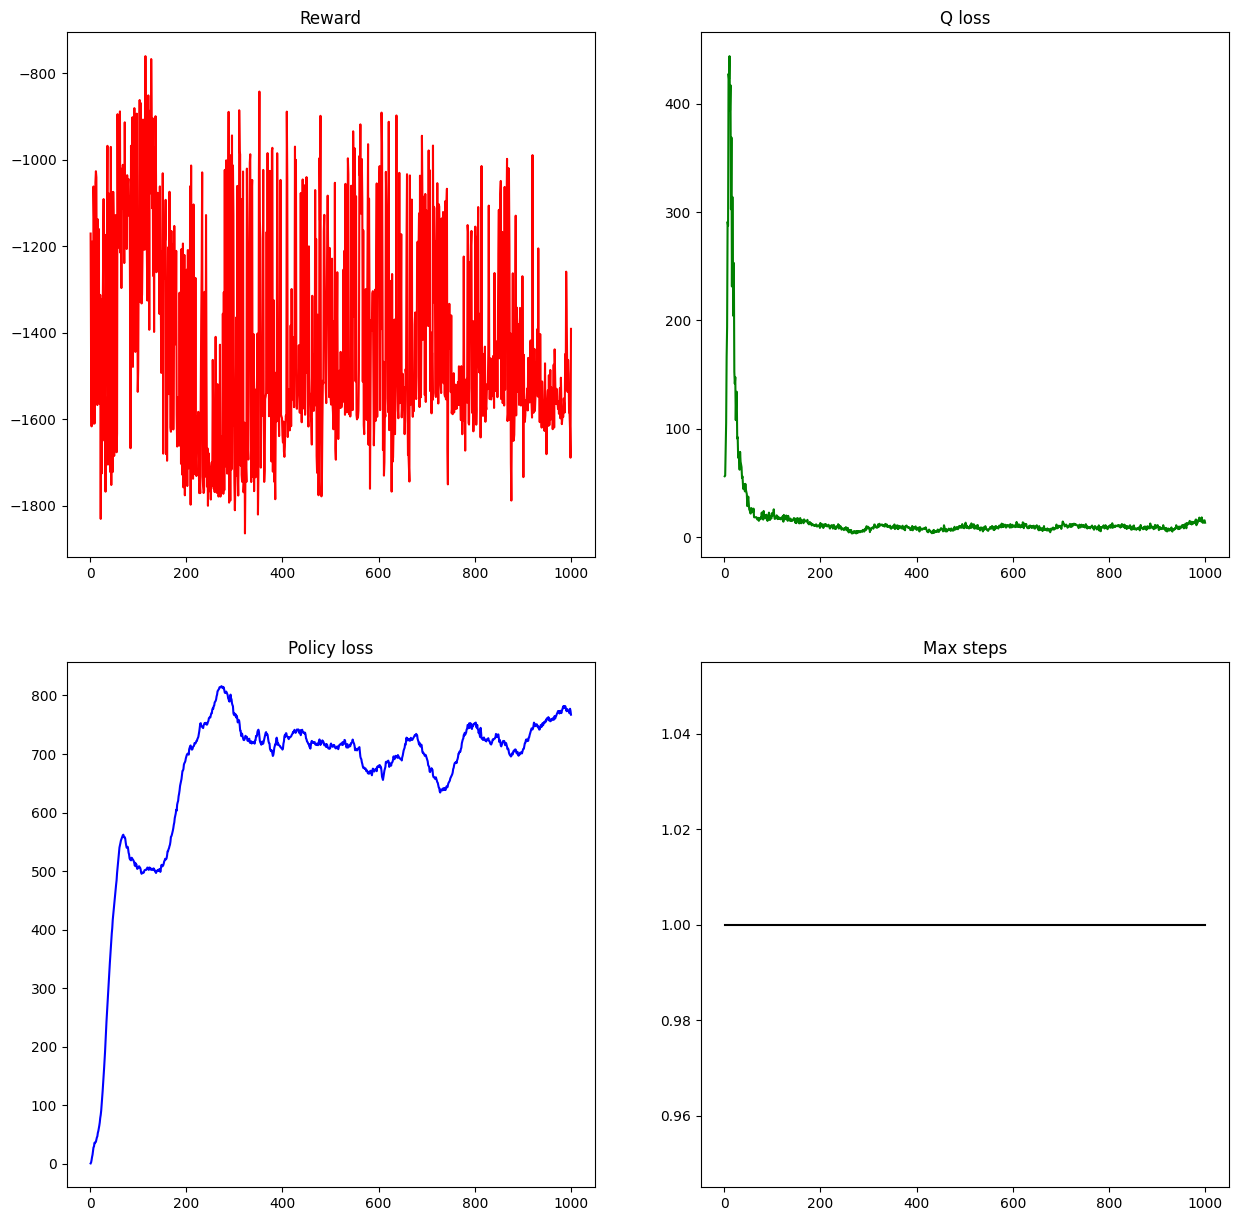

In [36]:
subplot(plot_reward, plot_policy, plot_q)

Text(0.5, 1.0, 'Policy loss')

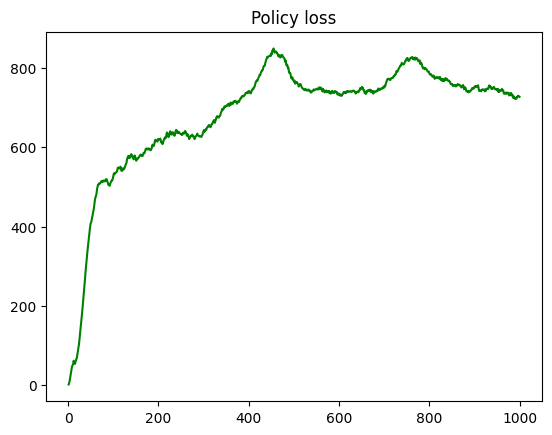

In [331]:
q = list(zip(*plot_policy))
plt.plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
plt.title('Policy loss')

In [ ]:
cumulative_reward = 0
for episode in tqdm(range(100)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        # how many iterations??
        action = agent.compute_action(state = current_state)
        # transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        
        # TODO: buffer_start = ??
        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            # TODO: sample random from 0 to 200??
            #indices = np.random.randint(0, 200, nr_of_samples)
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # 1-step TD-learning rule
            #TODO: the last update in each episode should use q = 0 !!
            policy_loss = test_policy(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, network)
                       
        
        current_state = deepcopy(next_state)
        cumulative_reward += reward
    # plot_q.append([loss, episode])
    try:
        # plot_reward.append([ep_reward, episode+1])
        # plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # q_losses.append(q_loss.item())

        if (episode % 10 == 0):
            print(policy_loss.item())
    except:
        continue


In [ ]:
average_reward = cumulative_reward / 100

In [187]:
def run_test_episodes(env, policy, num_episodes):
    cumulative_reward = 0

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        done = False

        # TODO: how many iterations??
        while not done:
            action = policy.select_action(state)
            next_state, reward, done, _ = env.step(action)
            cumulative_reward += reward
            state = next_state

    average_reward = cumulative_reward / num_episodes
    return average_reward

In [43]:
policy_loss

tensor(47.8445, grad_fn=<MeanBackward0>)